### Data Preparation and EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# get the data ready
df = pd.read_csv('/Data/climate_change_dataset.csv')

# check which countries are in our dataset
unique_countries = df['Country'].unique()
print("Countries in dataset:", unique_countries)

# mark countries as developed or developing
developed_list = ['USA', 'UK', 'France', 'Germany', 'Australia', 'Japan',
                  'Canada', 'Italy', 'Spain', 'Netherlands', 'Switzerland',
                  'Sweden', 'Norway']

# filter to only keep countries in our dataset
developed_countries = [c for c in developed_list if c in unique_countries]
print("Developed countries in our data:", developed_countries)

# add development status column
df['Development_Status'] = df['Country'].apply(
    lambda x: 'Developed' if x in developed_countries else 'Developing')

# basic stats to understand the data
print("Dataset Shape:", df.shape)
print("\nData Overview:")
print(df.describe())

# CO2 trends over time by development status
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='CO2 Emissions (Tons/Capita)',
             hue='Development_Status', ci=None)
plt.title('CO2 Emissions Trends by Development Status')
plt.grid(True, alpha=0.3)
plt.show()

# correlation heatmap to see relationships
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Climate Variables')
plt.tight_layout()
plt.show()

# sort data for time-based analysis
df_sorted = df.sort_values(['Country', 'Year'])

# create previous year features
df_sorted['Prev_Temperature'] = df_sorted.groupby('Country')['Avg Temperature (°C)'].shift(1)
df_sorted['Prev_SeaLevel'] = df_sorted.groupby('Country')['Sea Level Rise (mm)'].shift(1)
df_sorted['Prev_Rainfall'] = df_sorted.groupby('Country')['Rainfall (mm)'].shift(1)
df_sorted['Prev_RenewableEnergy'] = df_sorted.groupby('Country')['Renewable Energy (%)'].shift(1)
df_sorted['Prev_ExtremeWeather'] = df_sorted.groupby('Country')['Extreme Weather Events'].shift(1)
df_sorted['Prev_ForestArea'] = df_sorted.groupby('Country')['Forest Area (%)'].shift(1)

# add some YOY change metrics
df_sorted['Temp_Change'] = df_sorted['Avg Temperature (°C)'] - df_sorted['Prev_Temperature']
df_sorted['SeaLevel_Change'] = df_sorted['Sea Level Rise (mm)'] - df_sorted['Prev_SeaLevel']
df_sorted['Rainfall_Change'] = df_sorted['Rainfall (mm)'] - df_sorted['Prev_Rainfall']

# drop NaN rows
df_sorted = df_sorted.dropna()

# prepare features and target
X = df_sorted.drop(['CO2 Emissions (Tons/Capita)', 'Country'], axis=1)
y = df_sorted['CO2 Emissions (Tons/Capita)']

# convert categorical to numeric
X = pd.get_dummies(X, drop_first=True)

# scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# split data chronologically
cutoff_year = df_sorted['Year'].quantile(0.8)
train_indices = df_sorted[df_sorted['Year'] <= cutoff_year].index
test_indices = df_sorted[df_sorted['Year'] > cutoff_year].index

X_train = X_scaled.loc[train_indices]
X_test = X_scaled.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

FileNotFoundError: [Errno 2] No such file or directory: '/content/climate_change_dataset.csv'

### SMA

SMA Baseline Results:
MSE: 37.8693
R²: -0.2734
MAE: 5.1623


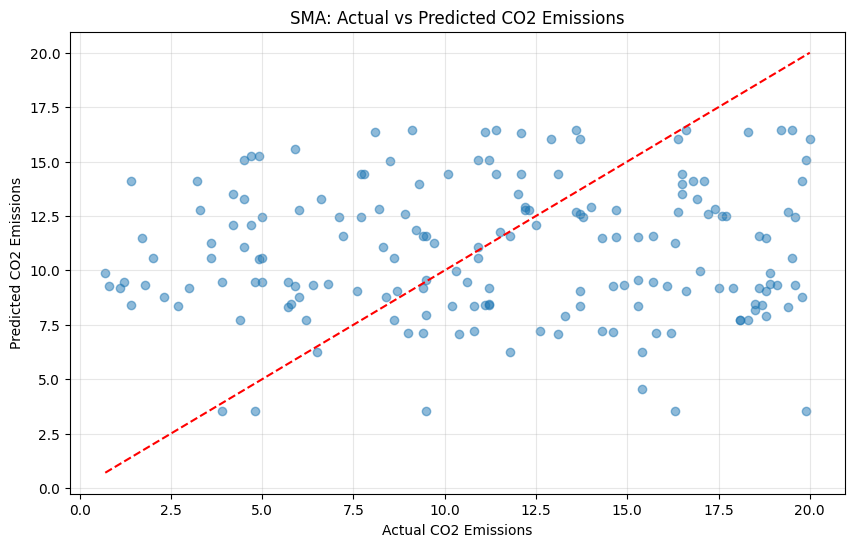

In [ ]:
# SMA baseline model
def generate_sma_predictions(data, test_idx, window=3):
    predictions = []

    # store country averages
    country_avgs = data.groupby('Country')['CO2 Emissions (Tons/Capita)'].mean().to_dict()
    global_avg = data['CO2 Emissions (Tons/Capita)'].mean()

    for idx in test_idx:
        row = data.loc[idx]
        country = row['Country']
        year = row['Year']

        # find data for this country from earlier years
        past_data = data[(data['Country'] == country) & (data['Year'] < year)]

        if len(past_data) >= window:
            recent = past_data.sort_values('Year', ascending=False).head(window)
            pred = recent['CO2 Emissions (Tons/Capita)'].mean()
        elif len(past_data) > 0:
            pred = past_data['CO2 Emissions (Tons/Capita)'].mean()
        else:
            pred = country_avgs.get(country, global_avg)

        predictions.append(pred)

    return np.array(predictions)


y_pred_sma = generate_sma_predictions(df_sorted, test_indices, window=3)

# evaluate the model
sma_mse = mean_squared_error(y_test, y_pred_sma)
sma_r2 = r2_score(y_test, y_pred_sma)
sma_mae = mean_absolute_error(y_test, y_pred_sma)

print(f"SMA Baseline Results:")
print(f"MSE: {sma_mse:.4f}")
print(f"R²: {sma_r2:.4f}")
print(f"MAE: {sma_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sma, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('SMA: Actual vs Predicted CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

### Linear Regression

Best Ridge alpha: 100.0
Best Lasso alpha: 1.0
Linear Regression Results:
MSE: 11.7004
R²: -0.1916
MAE: 2.6334
Ridge Regression Results:
MSE: 11.6146
R²: -0.1828
MAE: 2.6439
Lasso Regression Results:
MSE: 11.5128
R²: -0.1725
MAE: 2.6704

Best linear model: Lasso Regression


<ipython-input-4-0a63d09c63c7>:85: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, max_coef * 1.1)


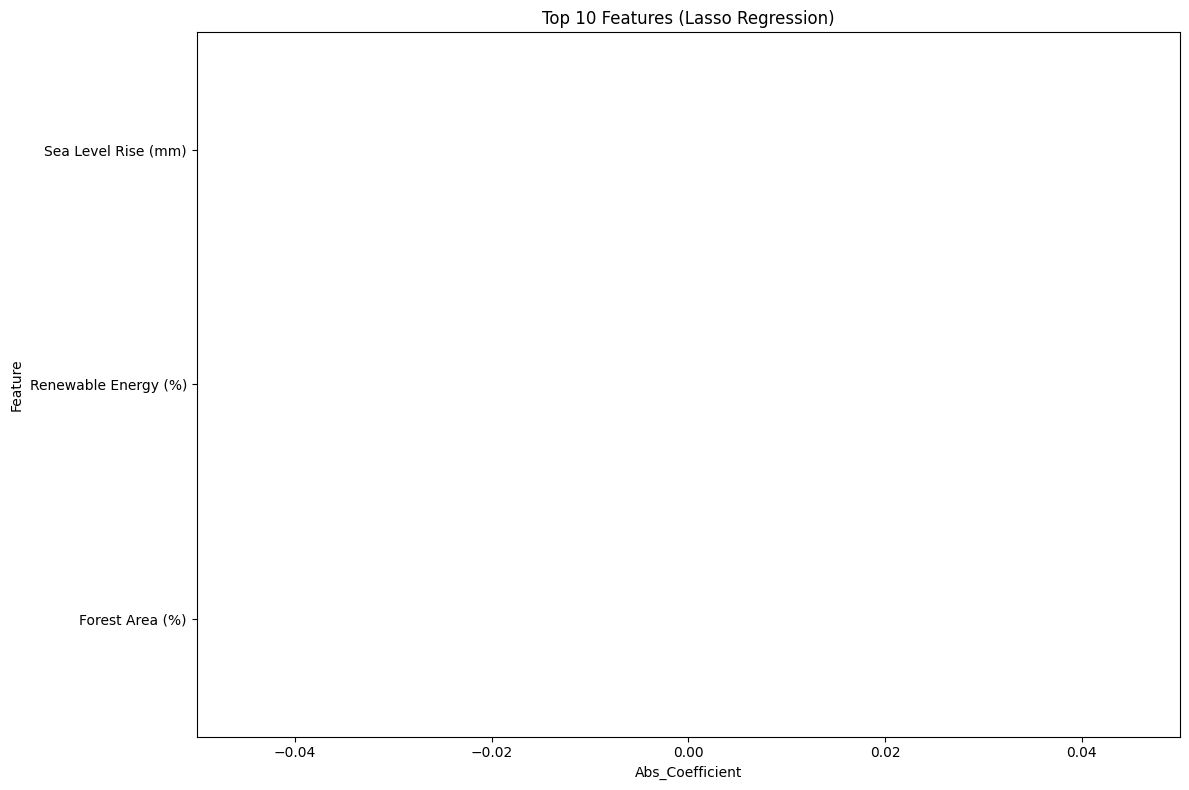

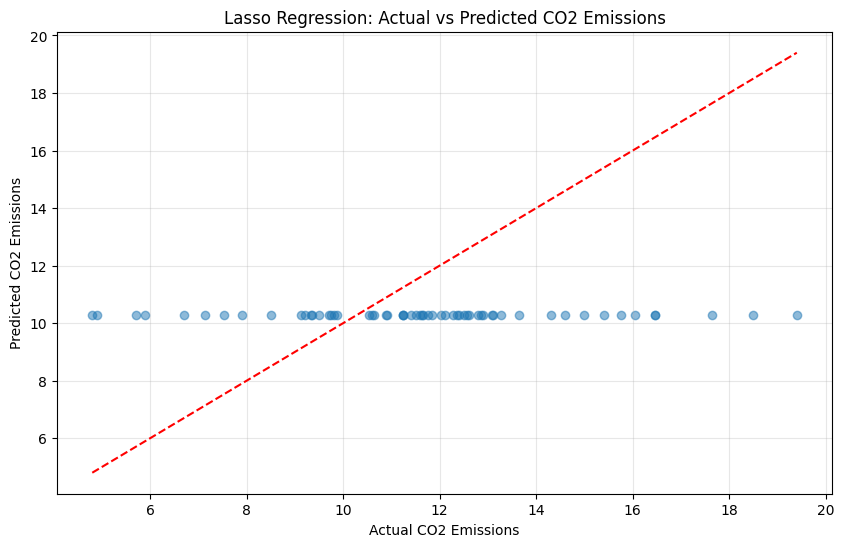

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# function to show model performance
def evaluate_model(y_true, y_pred, model_name):
   mse = mean_squared_error(y_true, y_pred)
   r2 = r2_score(y_true, y_pred)
   mae = mean_absolute_error(y_true, y_pred)

   print(f"{model_name} Results:")
   print(f"MSE: {mse:.4f}")
   print(f"R²: {r2:.4f}")
   print(f"MAE: {mae:.4f}")

   return mse, r2, mae

# try a few linear models with regularization
ridge = Ridge()
lasso = Lasso()

# try different alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'alpha': alphas}

# find best ridge model
ridge_grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge alpha: {best_ridge.alpha}")

# find best lasso model
lasso_grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"Best Lasso alpha: {best_lasso.alpha}")

# regular linear regression (no regularization)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# make predictions with all models
y_pred_lr = lr_model.predict(X_test)
y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)

# check performance
lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")
ridge_metrics = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
lasso_metrics = evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# find best working linear model
linear_models = {
   "Linear Regression": (y_pred_lr, lr_metrics),
   "Ridge Regression": (y_pred_ridge, ridge_metrics),
   "Lasso Regression": (y_pred_lasso, lasso_metrics)
}

# pick best one by R² score
best_linear_name = max(linear_models.items(), key=lambda x: x[1][1][1])[0]
best_linear_pred = linear_models[best_linear_name][0]
print(f"\nBest linear model: {best_linear_name}")

# feature importance for best model
if best_linear_name == "Linear Regression":
   coefs = lr_model.coef_
elif best_linear_name == "Ridge Regression":
   coefs = best_ridge.coef_
else:
   coefs = best_lasso.coef_

# organize feature importances
feature_importance_lr = pd.DataFrame({
   'Feature': X.columns,
   'Coefficient': coefs
})
feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

# plot top features
plt.figure(figsize=(12, 8))
top_10 = feature_importance_lr.head(10)
ax = sns.barplot(x='Abs_Coefficient', y='Feature', data=top_10)
plt.title(f'Top 10 Features ({best_linear_name})')
max_coef = top_10['Abs_Coefficient'].max()
plt.xlim(0, max_coef * 1.1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_linear_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title(f'{best_linear_name}: Actual vs Predicted CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

### Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Random Forest Results:
MSE: 31.2418
R²: -0.0505
MAE: 4.7563


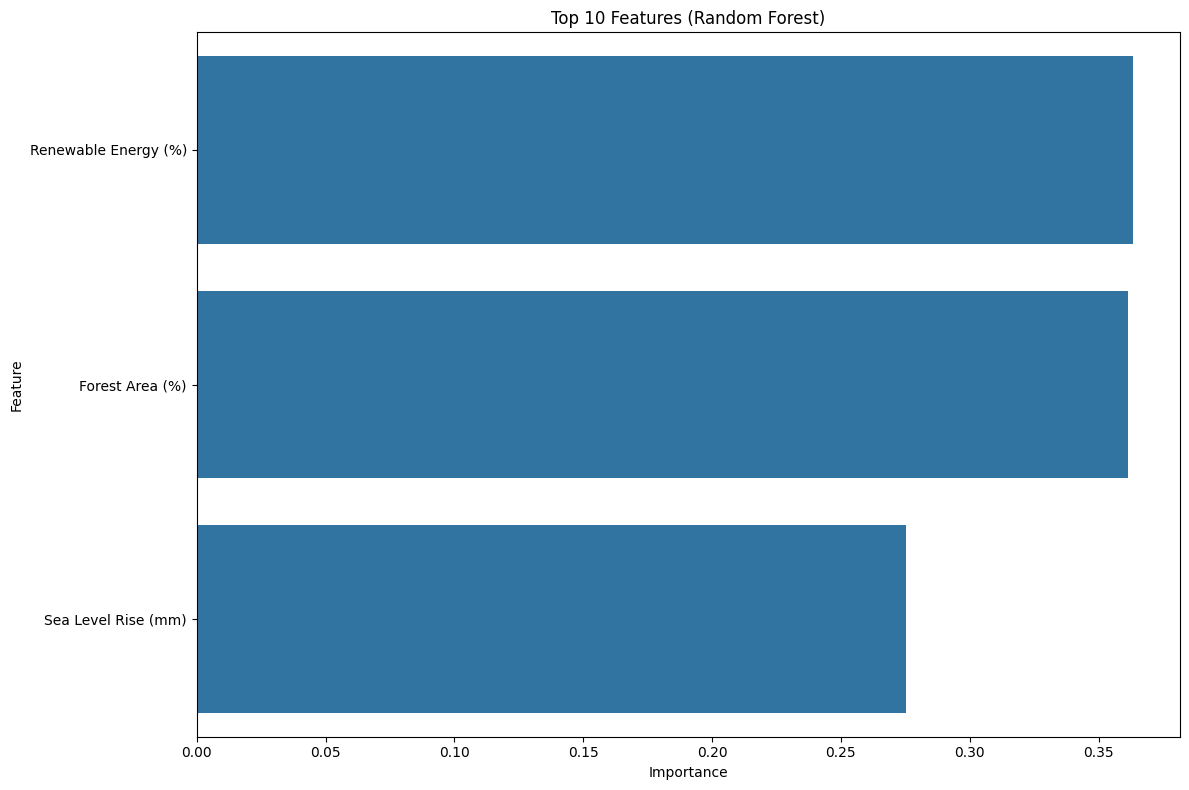

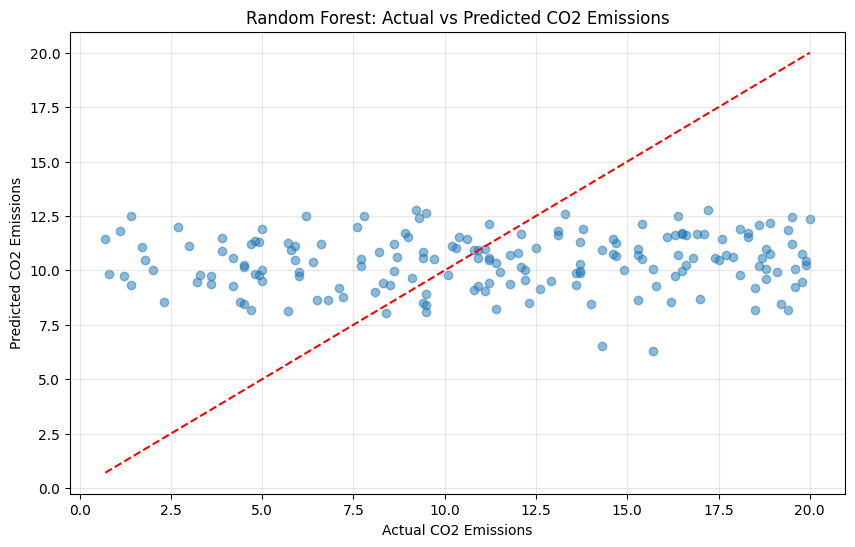

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# try different RF parameters
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# randomized search takes less time than grid search
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # try 20 combinations
    cv=5,
    verbose=1,  # show progress
    random_state=42,
    n_jobs=-1,  # use all cores
    scoring='neg_mean_squared_error'  # optimize for MSE
)

# fit the random forest model
rf_random.fit(X_train, y_train)

# get best model
best_rf = rf_random.best_estimator_
print(f"Best Random Forest Parameters: {rf_random.best_params_}")

# predict using best model
y_pred_rf = best_rf.predict(X_test)

# check performance
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")

# look at feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

# show top features
plt.figure(figsize=(12, 8))
top_10_rf = feature_importance_rf.head(10)
sns.barplot(x='Importance', y='Feature', data=top_10_rf)
plt.title('Top 10 Features (Random Forest)')
plt.tight_layout()
plt.show()

# plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Random Forest: Actual vs Predicted CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

### XGBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
XGBoost Results:
MSE: 31.3166
R²: -0.0531
MAE: 4.7352


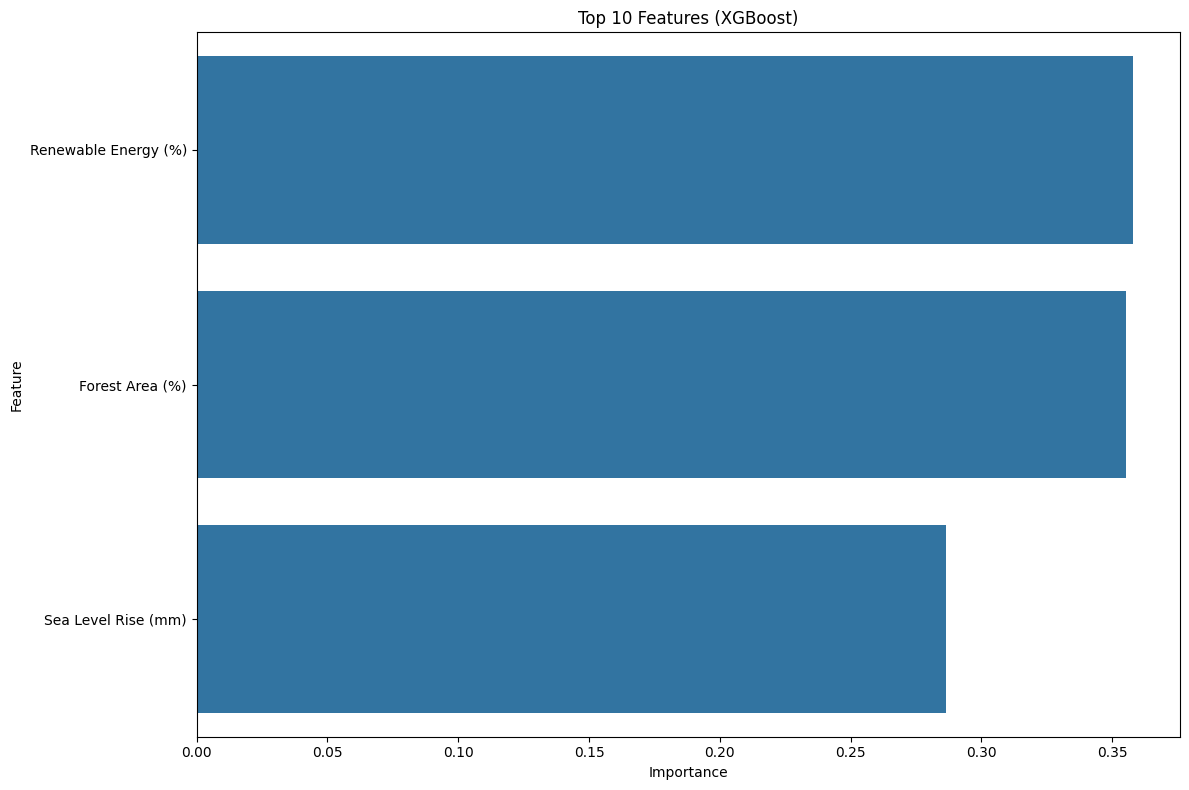

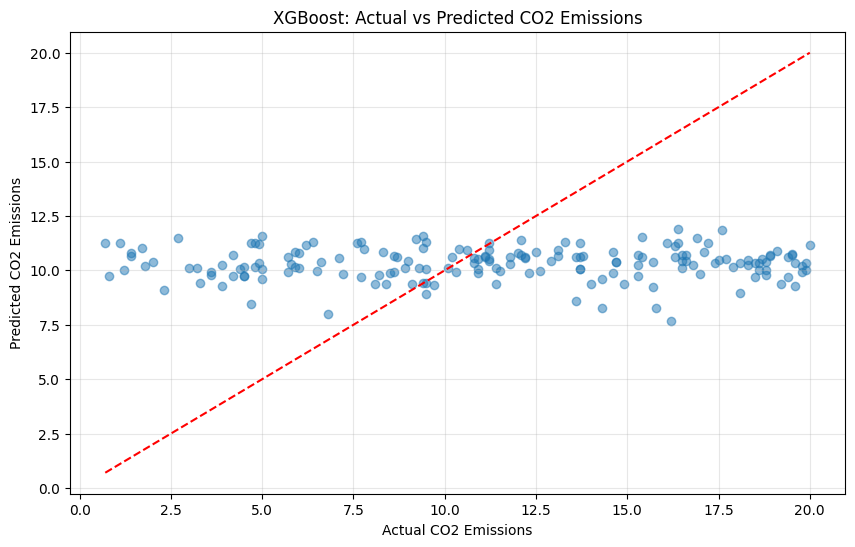

In [ ]:
from xgboost import XGBRegressor

# try different params
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# random search to find best params
xgb_random = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=xgb_params,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# train model
xgb_random.fit(X_train, y_train)

# get best model
best_xgb = xgb_random.best_estimator_
print(f"Best XGBoost Parameters: {xgb_random.best_params_}")

# evaluate model
y_pred_xgb = best_xgb.predict(X_test)

xgb_metrics = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
})
feature_importance_xgb = feature_importance_xgb.sort_values('Importance', ascending=False)

# top features
plt.figure(figsize=(12, 8))
top_10_xgb = feature_importance_xgb.head(10)
sns.barplot(x='Importance', y='Feature', data=top_10_xgb)
plt.title('Top 10 Features (XGBoost)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('XGBoost: Actual vs Predicted CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

### Support Vector Regression

Starting SVR training...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVR Parameters: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.1, 'C': 0.1}
Support Vector Regression Results:
MSE: 30.8368
R²: -0.0369
MAE: 4.7166


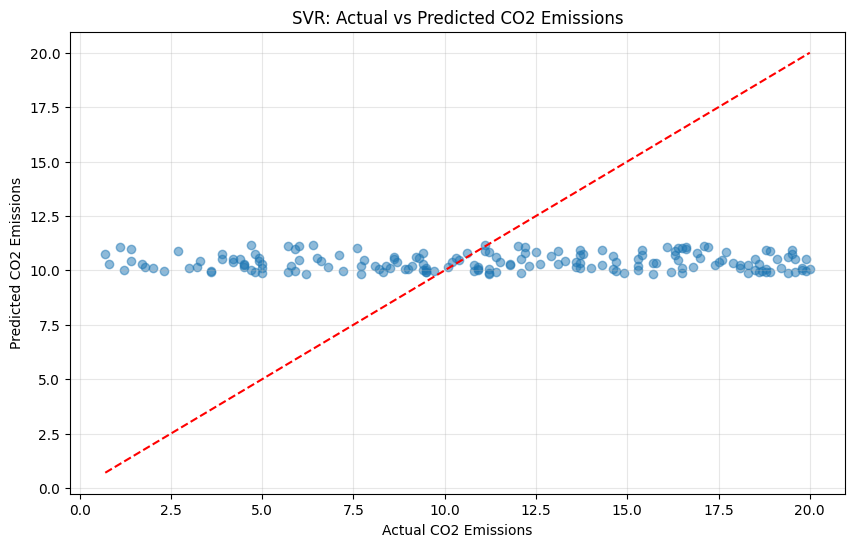

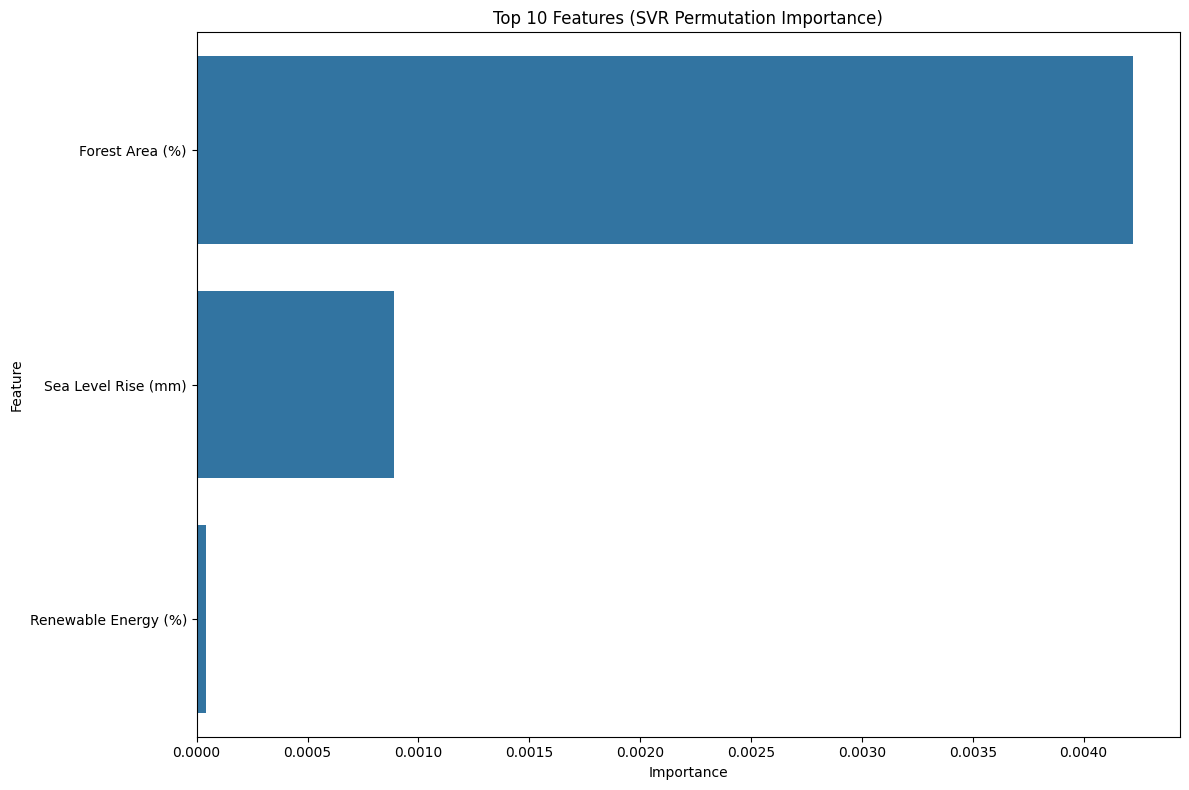

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# parameters to try
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01],  # kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'],  # kernel type
    'epsilon': [0.05, 0.1, 0.2]  # margin of tolerance
}

# use andom search to find good parameters faster
svr_random = RandomizedSearchCV(
    SVR(),
    param_distributions=svr_param_grid,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

print("Starting SVR training...")
svr_random.fit(X_train, y_train)

# best model
best_svr = svr_random.best_estimator_
print(f"Best SVR Parameters: {svr_random.best_params_}")

# test it
y_pred_svr = best_svr.predict(X_test)

# evaluate performance
svr_metrics = evaluate_model(y_test, y_pred_svr, "Support Vector Regression")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('SVR: Actual vs Predicted CO2 Emissions')
plt.grid(True, alpha=0.3)
plt.show()

# need to use permutation importance as SVR doesn't give feature importance directly
from sklearn.inspection import permutation_importance

result = permutation_importance(best_svr, X_test, y_test, n_repeats=10, random_state=42)
svr_importances = result.importances_mean

# feature importances
feature_importance_svr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': svr_importances
})
feature_importance_svr = feature_importance_svr.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_10_svr = feature_importance_svr.head(10)
sns.barplot(x='Importance', y='Feature', data=top_10_svr)
plt.title('Top 10 Features (SVR Permutation Importance)')
plt.tight_layout()
plt.show()

### Model Comparision




Model Comparison:
               Model        MSE        R²       MAE
0     SMA (Baseline)  37.869350 -0.273408  5.162311
1  Best Linear Model  31.068033 -0.044704  4.766104
2      Random Forest  32.999448 -0.109651  4.860058
3            XGBoost  32.042958 -0.077487  4.786145
4                SVR  30.916973 -0.039625  4.747815


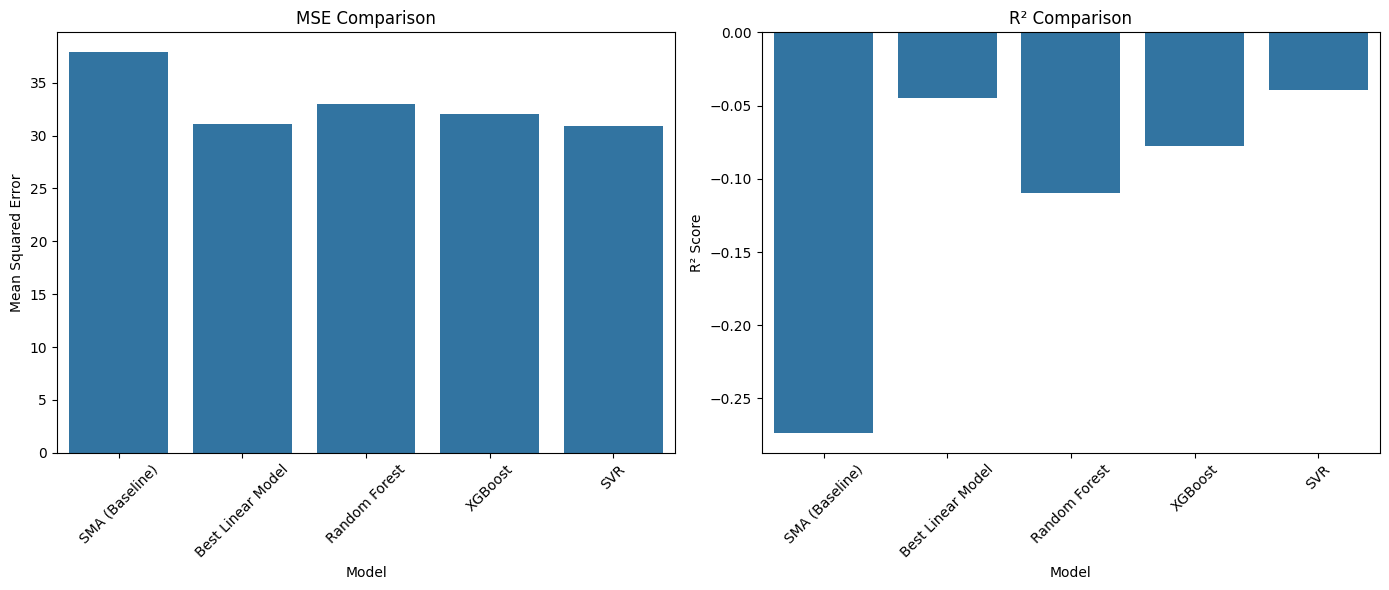


Best Model Performance on Developed Countries:
MSE: 32.5649
R²: -0.0302
MAE: 4.8357

Best Model Performance on Developing Countries:
MSE: 29.5119
R²: -0.0487
MAE: 4.6728

Top 5 Important Features by Model:
Linear: Year, Avg Temperature (°C), Sea Level Rise (mm), Rainfall (mm), Population
Random Forest: Renewable Energy (%), Population, Rainfall (mm), Prev_ForestArea, Rainfall_Change
XGBoost: Rainfall_Change, SeaLevel_Change, Renewable Energy (%), Prev_RenewableEnergy, Temp_Change
SVR: Development_Status_Developing, Avg Temperature (°C), Prev_ForestArea, Forest Area (%), Prev_Temperature

Common Important Features Across Models:
Prev_ForestArea: Found in 2 models (Random Forest, SVR)
Rainfall (mm): Found in 2 models (Linear, Random Forest)
Population: Found in 2 models (Linear, Random Forest)
Avg Temperature (°C): Found in 2 models (Linear, SVR)
Rainfall_Change: Found in 2 models (Random Forest, XGBoost)
Renewable Energy (%): Found in 2 models (Random Forest, XGBoost)


In [ ]:
# compare all models
models = {
    'SMA (Baseline)': (y_pred_sma, sma_mse, sma_r2, sma_mae),
    'Best Linear Model': (best_linear_pred, linear_models[best_linear_name][1][0],
                          linear_models[best_linear_name][1][1], linear_models[best_linear_name][1][2]),
    'Random Forest': (y_pred_rf, rf_metrics[0], rf_metrics[1], rf_metrics[2]),
    'XGBoost': (y_pred_xgb, xgb_metrics[0], xgb_metrics[1], xgb_metrics[2]),
    'SVR': (y_pred_svr, svr_metrics[0], svr_metrics[1], svr_metrics[2]),
}

# table of results
results = []
for name, metrics in models.items():
    results.append({'Model': name, 'MSE': metrics[1], 'R²': metrics[2], 'MAE': metrics[3]})

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('R² Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# model performance by development status
developed_idx = df_sorted[df_sorted['Development_Status'] == 'Developed'].index
developing_idx = df_sorted[df_sorted['Development_Status'] == 'Developing'].index

developed_test = list(set(test_indices).intersection(developed_idx))
developing_test = list(set(test_indices).intersection(developing_idx))

# best overall model
best_model_name = max(models.items(), key=lambda x: x[1][2])[0]
best_model_preds = models[best_model_name][0]

# best model performace on developed countries
if developed_test:
    developed_actual = y_test.loc[developed_test]
    developed_pred = [best_model_preds[list(y_test.index).index(idx)] for idx in developed_test]
    developed_metrics = (
        mean_squared_error(developed_actual, developed_pred),
        r2_score(developed_actual, developed_pred),
        mean_absolute_error(developed_actual, developed_pred)
    )
    print(f"\nBest Model Performance on Developed Countries:")
    print(f"MSE: {developed_metrics[0]:.4f}")
    print(f"R²: {developed_metrics[1]:.4f}")
    print(f"MAE: {developed_metrics[2]:.4f}")

# best model performance on developing countries
if developing_test:
    developing_actual = y_test.loc[developing_test]
    developing_pred = [best_model_preds[list(y_test.index).index(idx)] for idx in developing_test]
    developing_metrics = (
        mean_squared_error(developing_actual, developing_pred),
        r2_score(developing_actual, developing_pred),
        mean_absolute_error(developing_actual, developing_pred)
    )
    print(f"\nBest Model Performance on Developing Countries:")
    print(f"MSE: {developing_metrics[0]:.4f}")
    print(f"R²: {developing_metrics[1]:.4f}")
    print(f"MAE: {developing_metrics[2]:.4f}")

# top features from each model
top_features = {
    'Linear': feature_importance_lr.head(5)['Feature'].tolist(),
    'Random Forest': feature_importance_rf.head(5)['Feature'].tolist(),
    'XGBoost': feature_importance_xgb.head(5)['Feature'].tolist(),
    'SVR': feature_importance_svr.head(5)['Feature'].tolist(),
}

print("\nTop 5 Important Features by Model:")
for model, features in top_features.items():
    print(f"{model}: {', '.join(features)}")

# important features repeating in multiple models
all_top_features = set()
for features in top_features.values():
    all_top_features.update(features)

common_features = []
for feature in all_top_features:
    models_with_feature = [model for model, features in top_features.items() if feature in features]
    if len(models_with_feature) > 1:
        common_features.append((feature, len(models_with_feature), ', '.join(models_with_feature)))

print("\nCommon Important Features Across Models:")
for feature, count, models in sorted(common_features, key=lambda x: x[1], reverse=True):
    print(f"{feature}: Found in {count} models ({models})")